### Cliff Walking Example
#### All code is taken from https://github.com/JaeDukSeo/reinforcement-learning-an-introduction/blob/master/chapter06/CliffWalking.py 

#### to do:
1. Explain how the Q-learning works.
2. How is the Q-learning method implementation different from SARSA discussed in the previous activity?
3. Be prepared to discuss the graph, what it presents, and why.

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# world height
WORLD_HEIGHT = 4

# world width
WORLD_WIDTH = 12

# probability for exploration
EPSILON = 0.1

# step size
ALPHA = 0.5

# gamma for Q-Learning and Expected Sarsa
GAMMA = 1

# all possible actions
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3
actions = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]

# initial state action pair values
stateActionValues = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
startState = [3, 0]
goalState = [3, 11]

# reward for each action in each state
actionRewards = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
actionRewards[:, :, :] = -1.0
actionRewards[2, 1:11, ACTION_DOWN] = -100.0
actionRewards[3, 0, ACTION_RIGHT] = -100.0

In [3]:
# set up destinations for each action in each state
actionDestination = []
for i in range(0, WORLD_HEIGHT):
    actionDestination.append([])
    for j in range(0, WORLD_WIDTH):
        destinaion = dict()
        destinaion[ACTION_UP] = [max(i - 1, 0), j]
        destinaion[ACTION_LEFT] = [i, max(j - 1, 0)]
        destinaion[ACTION_RIGHT] = [i, min(j + 1, WORLD_WIDTH - 1)]
        if i == 2 and 1 <= j <= 10:
            destinaion[ACTION_DOWN] = startState
        else:
            destinaion[ACTION_DOWN] = [min(i + 1, WORLD_HEIGHT - 1), j]
        actionDestination[-1].append(destinaion)
actionDestination[3][0][ACTION_RIGHT] = startState

# choose an action based on epsilon greedy algorithm
def chooseAction(state, stateActionValues):
    if np.random.binomial(1, EPSILON) == 1:
        return np.random.choice(actions)
    else:
        values_ = stateActionValues[state[0], state[1], :]
        return np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])


In [4]:
# an episode with Sarsa
# @stateActionValues: values for state action pair, will be updated
# @expected: if True, will use expected Sarsa algorithm
# @stepSize: step size for updating
# @return: total rewards within this episode
def sarsa(stateActionValues, expected=False, stepSize=ALPHA):
    currentState = startState
    currentAction = chooseAction(currentState, stateActionValues)
    rewards = 0.0
    while currentState != goalState:
        newState = actionDestination[currentState[0]][currentState[1]][currentAction]
        newAction = chooseAction(newState, stateActionValues)
        reward = actionRewards[currentState[0], currentState[1], currentAction]
        rewards += reward
        if not expected:
            valueTarget = stateActionValues[newState[0], newState[1], newAction]
        else:
            # calculate the expected value of new state
            valueTarget = 0.0
            actionValues = stateActionValues[newState[0], newState[1], :]
            bestActions = np.argwhere(actionValues == np.max(actionValues))
            for action in actions:
                if action in bestActions:
                    valueTarget += ((1.0 - EPSILON) / len(bestActions) + EPSILON / len(actions)) * stateActionValues[newState[0], newState[1], action]
                else:
                    valueTarget += EPSILON / len(actions) * stateActionValues[newState[0], newState[1], action]
        valueTarget *= GAMMA
        # Sarsa update
        stateActionValues[currentState[0], currentState[1], currentAction] += stepSize * (reward +
            valueTarget - stateActionValues[currentState[0], currentState[1], currentAction])
        currentState = newState
        currentAction = newAction
    return rewards

In [5]:
# an episode with Q-Learning
# @stateActionValues: values for state action pair, will be updated
# @expected: if True, will use expected Sarsa algorithm
# @stepSize: step size for updating
# @return: total rewards within this episode
def qLearning(stateActionValues, stepSize=ALPHA):
    currentState = startState
    rewards = 0.0
    while currentState != goalState:
        currentAction = chooseAction(currentState, stateActionValues)
        reward = actionRewards[currentState[0], currentState[1], currentAction]
        rewards += reward
        newState = actionDestination[currentState[0]][currentState[1]][currentAction]
        # Q-Learning update
        stateActionValues[currentState[0], currentState[1], currentAction] += stepSize * (
            reward + GAMMA * np.max(stateActionValues[newState[0], newState[1], :]) -
            stateActionValues[currentState[0], currentState[1], currentAction])
        currentState = newState
    return rewards

In [6]:
# print optimal policy
def printOptimalPolicy(stateActionValues):
    optimalPolicy = []
    for i in range(0, WORLD_HEIGHT):
        optimalPolicy.append([])
        for j in range(0, WORLD_WIDTH):
            if [i, j] == goalState:
                optimalPolicy[-1].append('G')
                continue
            bestAction = np.argmax(stateActionValues[i, j, :])
            if bestAction == ACTION_UP:
                optimalPolicy[-1].append('U')
            elif bestAction == ACTION_DOWN:
                optimalPolicy[-1].append('D')
            elif bestAction == ACTION_LEFT:
                optimalPolicy[-1].append('L')
            elif bestAction == ACTION_RIGHT:
                optimalPolicy[-1].append('R')
    for row in optimalPolicy:
        print(row)

In [7]:
# figure 6.5
# Use 20 independent runs instead of a single run to draw the figure
# Sarsa converges to the safe path, while Q-Learning converges to the optimal path
def figure6_5():
    # averaging the reward sums from 10 successive episodes
    averageRange = 10

    # episodes of each run
    nEpisodes = 500

    # perform 20 independent runs
    runs = 20

    rewardsSarsa = np.zeros(nEpisodes)
    rewardsQLearning = np.zeros(nEpisodes)
    for run in range(0, runs):
        stateActionValuesSarsa = np.copy(stateActionValues)
        stateActionValuesQLearning = np.copy(stateActionValues)
        for i in range(0, nEpisodes):
            # cut off the value by -100 to draw the figure more elegantly
            rewardsSarsa[i] += max(sarsa(stateActionValuesSarsa), -100)
            rewardsQLearning[i] += max(qLearning(stateActionValuesQLearning), -100)

    # averaging over independt runs
    rewardsSarsa /= runs
    rewardsQLearning /= runs

    # averaging over successive episodes
    smoothedRewardsSarsa = np.copy(rewardsSarsa)
    smoothedRewardsQLearning = np.copy(rewardsQLearning)
    for i in range(averageRange, nEpisodes):
        smoothedRewardsSarsa[i] = np.mean(rewardsSarsa[i - averageRange: i + 1])
        smoothedRewardsQLearning[i] = np.mean(rewardsQLearning[i - averageRange: i + 1])

    # display optimal policy
    print('Sarsa Optimal Policy:')
    printOptimalPolicy(stateActionValuesSarsa)
    print('Q-Learning Optimal Policy:')
    printOptimalPolicy(stateActionValuesQLearning)

    # draw reward curves
    plt.figure(1)
    plt.plot(smoothedRewardsSarsa, label='Sarsa')
    plt.plot(smoothedRewardsQLearning, label='Q-Learning')
    plt.xlabel('Episodes')
    plt.ylabel('Sum of rewards during episode')
    plt.legend()


Sarsa Optimal Policy:
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['U', 'L', 'U', 'R', 'R', 'L', 'R', 'U', 'U', 'R', 'R', 'D']
['U', 'U', 'R', 'R', 'U', 'L', 'U', 'U', 'R', 'R', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'G']
Q-Learning Optimal Policy:
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D', 'D', 'D', 'D']
['R', 'D', 'R', 'D', 'D', 'R', 'D', 'R', 'R', 'D', 'D', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'G']


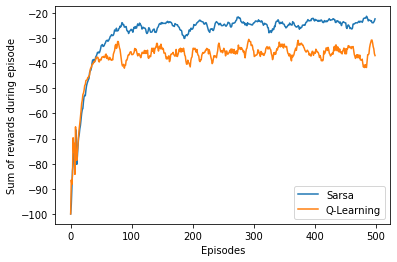

In [8]:
figure6_5()
plt.show()